# Проект e-commerce. 
Дана некоторая платформа онлайн продаж, из которой выгружены следующие данные:
* уникальные идентификаторы пользователей;
* заказы; 
* товарные позиции, входящие в заказы.  

Необходимо проанализировать совершенные покупки и ответить на следующие вопросы:
1. Сколько пользователей, которые совершили покупку только один раз?    
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?   
3. По каждому товару определить, в какой день недели товар чаще всего покупается. 
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?    
5. Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.
6. Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию.  

Файлы:  
**olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей**:  
* customer_id — позаказный идентификатор пользователя  
* customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)  
* customer_zip_code_prefix —  почтовый индекс пользователя  
* customer_city —  город доставки пользователя  
* customer_state —  штат доставки пользователя  

**olist_orders_dataset.csv —  таблица заказов**:  
* order_id —  уникальный идентификатор заказа (номер чека)  
* customer_id —  позаказный идентификатор пользователя  
* order_status —  статус заказа  
* order_purchase_timestamp —  время создания заказа  
* order_approved_at —  время подтверждения оплаты заказа  
* order_delivered_carrier_date —  время передачи заказа в логистическую службу  
* order_delivered_customer_date —  время доставки заказа  
* order_estimated_delivery_date —  обещанная дата доставки  

**olist_order_items_dataset.csv —  товарные позиции, входящие в заказы**:  
* order_id —  уникальный идентификатор заказа (номер чека)  
* order_item_id —  идентификатор товара внутри одного заказа  
* product_id —  ид товара (аналог штрихкода)  
* seller_id — ид производителя товара  
* shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
* price —  цена за единицу товара  
* freight_value —  вес товара  

Уникальные статусы заказов в таблице **olist_orders_dataset**:  
* created —  создан  
* approved —  подтверждён    
* invoiced —  выставлен счёт  
* processing —  в процессе сборки заказа  
* shipped —  отгружен со склада  
* delivered —  доставлен пользователю  
* unavailable —  недоступен  
* canceled —  отменён  

In [2]:
!pip install pandas

In [3]:
!pip install seaborn

In [54]:
!pip install numpy

In [7]:
# Импортируем нужные библиотеки:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode
import json

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 
#хотим, чтобы наши графики сразу интерактивно рисовались в Jupiter Notebook

In [8]:
# Считаем файлы с Яндекс Диска:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

# Создадим функцию
def get_download_url(public_key):
    '''Загружает содержимое из файла на Яндекс Диске с использованием API.
       Принимает на вход: public_key - публичный ключ файла на Яндекс Диске
       Возвращает: ссылку для скачивания содержимого этого файла''' 
    # Получаем загрузочную ссылку:
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = json.loads(response.text)['href']  
    return download_url 

In [12]:
# Ссылки на файлы
public_key_customers ='https://disk.yandex.ru/d/tGjQZI2LObVx-g'
public_key_orders = 'https://disk.yandex.ru/d/k9BFUbZ4zuSOew' 
public_key_order_items = 'https://disk.yandex.ru/d/C5a8d15NqRw4KA' 

# Скачаем данные с использованием функции get_download_url
df_customers = pd.read_csv(get_download_url(public_key_customers), sep = ',')
df_orders = pd.read_csv(get_download_url(public_key_orders), sep = ',')
df_order_items = pd.read_csv(get_download_url(public_key_order_items), sep = ',')

# Посчитаем число строк и колонок в датафреймах:
print('df_customers.shape:', df_customers.shape)
print('df_orders.shape:', df_orders.shape)
print('df_order_items.shape:', df_order_items.shape)

df_customers.shape: (99441, 5)
df_orders.shape: (99441, 8)
df_order_items.shape: (112650, 7)


In [14]:
# Преобразуем дату в формат DateTime:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_approved_at'] = pd.to_datetime(df_orders['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')

In [16]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [17]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [18]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [19]:
# Посчитаем число пропущенных значений:
print('Пропущенных значений в таблице customers:\n{}\n'.format(df_customers.isna().sum()))
print('Пропущенных значений в таблице orders:\n{}\n'.format(df_orders.isna().sum()))
print('Пропущенных значений в таблице order_items:\n{}\n'.format(df_order_items.isna().sum()))

# пропущенные значения присутствуют в датах с неоплаченными и недоставленными заказами. В остальном, пропущенных значений нет.

Пропущенных значений в таблице customers:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Пропущенных значений в таблице orders:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Пропущенных значений в таблице order_items:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64



In [21]:
# Посчитаем число повторяющихся строк:
print('Повторяющихся строк в таблице customers: {}'.format(df_customers.duplicated().sum()))
print('Повторяющихся строк в таблице orders: {}'.format(df_orders.duplicated().sum()))
print('Повторяющихся строк в таблице order_items: {}'.format(df_order_items.duplicated().sum()))

# повторяющихся строк нет ни в одной таблице. 

Повторяющихся строк в таблице customers: 0
Повторяющихся строк в таблице orders: 0
Повторяющихся строк в таблице order_items: 0


In [22]:
# Посчитаем число уникальных значений для каждой колонки:
print('Число уникальных значений в таблице customers:\n{}\n'.format(df_customers.nunique()))
print('Число уникальных значений в таблице orders:\n{}\n'.format(df_orders.nunique()))
print('Число уникальных значений в таблице order_items:\n{}\n'.format(df_order_items.nunique()))

Число уникальных значений в таблице customers:
customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Число уникальных значений в таблице orders:
order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

Число уникальных значений в таблице order_items:
order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64



Видим, что число уникальных значений в колонке "*customer_id*"  в таблицах **customers** и **orders** одно и то же, и равно 99441 (оно же равно числу строк в этих таблицах). То есть общая колонка "*customer_id*" для этих двух таблиц содержит уникальные значения, и при соединении по ней любым из методов merge не будет происходить декартового произведения строк.  
В то же время в таблице **order_items** строк всего 112650, а уникальных значений поля в каждой колонке меньше, чем число строк. Следовательно, каждая колонка содержит неуникальные значения поля, что, вероятно, связано с тем, что для одного и того же заказа может быть несколько товаров. При этом число уникальных значений в колонке "*order_id*" в таблице **order_items** всего 98666, что меньше, чем в таблице **orders** (99441). 

In [26]:
# Соединим два датафрейма customers и orders по уникальной колонке customer_id:
df_co = df_customers \
    .merge(df_orders, on ='customer_id', how = 'outer') 

df_co.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,6273,osasco,SP,5f79b5b0931d63f1a42989eb65b9da6e,delivered,2017-11-14 16:08:26,2017-11-14 16:35:32,2017-11-17 15:32:08,2017-11-28 15:41:30,2017-12-04
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,35550,itapecerica,MG,a44895d095d7e0702b6a162fa2dbeced,delivered,2017-07-16 09:40:32,2017-07-16 09:55:12,2017-07-19 19:09:37,2017-07-25 18:57:33,2017-08-04
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,29830,nova venecia,ES,316a104623542e4d75189bb372bc5f8d,delivered,2017-02-28 11:06:43,2017-02-28 11:15:20,2017-03-01 15:24:20,2017-03-06 08:57:49,2017-03-22
3,0002414f95344307404f0ace7a26f1d5,4893ad4ea28b2c5b3ddf4e82e79db9e6,39664,mendonca,MG,5825ce2e88d5346438686b0bba99e5ee,delivered,2017-08-16 13:09:20,2017-08-17 03:10:27,2017-08-19 11:34:29,2017-09-13 20:06:02,2017-09-14
4,000379cdec625522490c315e70c7a9fb,0b83f73b19c2019e182fd552c048a22c,4841,sao paulo,SP,0ab7fb08086d4af9141453c91878ed7a,delivered,2018-04-02 13:42:17,2018-04-04 03:10:19,2018-04-04 18:11:09,2018-04-13 20:21:08,2018-04-18


In [27]:
df_co.shape

# Получили табличку с пользователями и заказами, содержащую 99441 строку.
# С этой табличкой и дальше будем работать.

(99441, 12)

### Задание 1. Посчитать количество пользователей, которые совершили покупку только один раз.

***Покупкой*** можно считать заказ, который доставлен пользователю (т.е. имеет статус "delivered"). 

In [28]:
# Для каждого уникального пользователя посчитаем количество совершенных покупок. 
# Затем отфильтруем пользователей, которые совершили только одну покупку, и посчитаем их количество: 
df_co\
    .query('order_status == "delivered" ')\
    .groupby('customer_unique_id')\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'purchases'})\
    .query('purchases == 1').count()

# т.е. их 90557

purchases    90557
dtype: int64

Следовательно, 90557 пользователей совершили покупку только один раз.

### Задание 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Будем считать, что ***заказ не доставляется пользователю*** если он недоступен (unavailable) или отменен (canceled). 

In [29]:
# Создадим новый столбец месяц создания задаза "order_purchase_timestamp_month" с датой в формате 'YYYY-MM'
df_co['order_purchase_timestamp_month'] = df_co['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [30]:
# Отфильтруем заказы со статусом 'unavailable' и 'canceled'.
# Затем посчитаем для каждого месяца и для каждого статуса количество заказов:
df_not_delivered = df_co\
    .query('order_status in ("unavailable",  "canceled")')\
    .groupby(['order_purchase_timestamp_month', 'order_status'], as_index = False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'numb_orders'})

In [31]:
# Теперь для каждого статуса посчитаем среднее количество заказов:
df_not_delivered\
    .groupby(['order_status'], as_index = False)\
    .agg({'numb_orders': 'mean'})

,order_status,numb_orders
0,canceled,26.041667
1,unavailable,29.000000


Следовательно, в среднем в месяц недоставляется:  
* ококо 26 заказов со статусом "canceled";  
* 29 заказов со статусом "unavailable".

### Задание 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [103]:
# Соединим таблицу с товарными позициями (df_order_items) с нашей таблицей с заказами и покупателями (df_custom_orders):
df_coi = df_order_items.merge(df_co, on ='order_id', how = 'inner')

Помним, что order_delivered_customer_date — это время доставки заказа клиенту.  

Мы считатем, что **покупка** - это те заказы, которые были доставлены.  
Следовательно, день недели, когда была сделана покупка - это тот день недели, когда была сделана доставка.

In [104]:
# Добавим в нашу таблицу день недели доставки заказа:
df_coi['order_delivered_customer_day'] = df_coi['order_delivered_customer_date'].dt.day_name()

In [105]:
# Сначала отфильтруем данные со статусом заказа "delivered", чтобы отобрать только купленные товары.
# Затем по каждому дню недели и по каждому товару посчитаем число покупок (numb_products).
# Затем для каждого товара посчитаем максимальное число покупок.
df_coi.query('order_status == "delivered" ') \
    .groupby(['product_id', 'order_delivered_customer_day'], as_index = False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'numb_products'})\
    .groupby('product_id').max()

,order_delivered_customer_day,numb_products
product_id,,
00066f42aeeb9f3007548bb9d3f33c38,Wednesday,1
00088930e925c41fd95ebfe695fd2655,Saturday,1
0009406fd7479715e4bef61dd91f2462,Saturday,1
000b8f95fcb9e0096488278317764d19,Tuesday,1
000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
...,...,...
fff6177642830a9a94a0f2cba5e476d1,Tuesday,1
fff81cc3158d2725c0655ab9ba0f712c,Wednesday,1
fff9553ac224cec9d15d49f5a263411f,Monday,1


Получили нужную таблицу, в которой для каждого для каждого товара посчитано, в какой день недели товар чаще всего покупается.

### Задание 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

**Заметим**, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно будет учесть.

Помним, что order_delivered_customer_date — это время доставки заказа клиенту.  

Мы считатем, что **покупка** - это те заказы, которые были доставлены.  
Следовательно, месяц, когда была сделана покупка - это месяц, когда была сделана доставка.

df_co - датафрейм с пользователями и заказами

In [32]:
# Создадим новый столбец с месяцем, когда была сделана доставка "order_delivered_customer_month" с датой в формате 'YYYY-MM'
df_co['order_delivered_customer_month'] = df_co['order_delivered_customer_date'].dt.strftime('%Y-%m')

# Посчитаем число дней в каждом месяце, когда была сделана доставка:
df_co["order_delivered_customer_days_in_month"] = df_co["order_delivered_customer_date"].dt.daysinmonth

In [33]:
# Посчитаем число недель в месяце, когда была сделана доставка:
df_co["order_delivered_customer_week_in_month"] = df_co["order_delivered_customer_days_in_month"]/7

In [34]:
# Отфильтруем строки, в которых была совершена покупка.
# Отберем только нужные колонки
df_delivered = df_co.query('order_status == "delivered" ')\
                [['customer_unique_id', \
                  'order_delivered_customer_date', \
                 'order_delivered_customer_month', \
                 'order_delivered_customer_days_in_month', \
                 'order_delivered_customer_week_in_month']]

In [35]:
df_delivered.sort_values('order_delivered_customer_date').dropna()
# В таблице ниже видим, что первый (2016-10) и последний (2018-10) месяцы - неполные, и их лучше исключить из расчета.

,customer_unique_id,order_delivered_customer_date,order_delivered_customer_month,order_delivered_customer_days_in_month,order_delivered_customer_week_in_month
66443,f176923a0a4ab546c7287791ccb82193,2016-10-11 13:46:32,2016-10,31.0,4.428571
49296,1dc848c11c2985635c268ff3dea707eb,2016-10-11 14:46:49,2016-10,31.0,4.428571
55907,f99053da7416fd6d626451cd49e44e0f,2016-10-13 03:10:34,2016-10,31.0,4.428571
89262,acf599349b44e4e51d2beacb549313ad,2016-10-13 07:45:48,2016-10,31.0,4.428571
93059,664f7107c351f24b16b68919398730a0,2016-10-13 15:44:27,2016-10,31.0,4.428571
...,...,...,...,...,...
7734,c9f2b70eaddf459267a9de373aaf743b,2018-09-25 00:47:25,2018-09,30.0,4.285714
99304,3ae68a873484afec224de126a94c5974,2018-09-27 02:24:33,2018-09,30.0,4.285714
61569,4bc530761c1b59d33d7c6cb640d3ee78,2018-10-02 00:18:50,2018-10,31.0,4.428571
15433,232422c2db1f7c69daf3b0f0421ebb43,2018-10-11 16:41:14,2018-10,31.0,4.428571


In [36]:
# Исключим неполные месяцы в данных: 
df_delivered = df_delivered.query('(order_delivered_customer_month != ["2016-10", "2018-10"])' )

In [38]:
# Отфильтруем неполные месяцы, и посчитаем для каждого пользователя количество покупок в месяц:
df_purchases_per_month = df_co\
    .query('(order_status == "delivered") and (order_delivered_customer_month != ["2016-10", "2018-10"]) ')\
    .groupby(['customer_unique_id', 'order_delivered_customer_month'], as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns = {'order_id': 'purchases_per_month'})

In [39]:
df_purchases_per_month.sort_values('purchases_per_month')

,customer_unique_id,order_delivered_customer_month,purchases_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
63224,a9fbcde432c048fe5741d2c14006640d,2017-12,1
63223,a9fb026555bf90291457057bcd39f613,2017-12,1
63222,a9fa9a5b7dd54d11fd541b60aab448c8,2017-12,1
63221,a9fa874c06644dd6933dc79aff70540f,2017-05,1
...,...,...,...
66499,b2bd387fdc3cf05931f0f897d607dc88,2018-03,4
49047,83e7958a94bd7f74a9414d8782f87628,2017-01,4
14021,25a560b9a6006157838aab1bdbd68624,2017-04,4
67280,b4e4f24de1e8725b74e4a1f4975116ed,2018-03,4


In [40]:
# Соединим два датафрейма, чтобы добавить еще один столбец в данные: число покупок в месяц.
df_all_purchases = df_delivered.merge(df_purchases_per_month, \
                                      on=['order_delivered_customer_month', 'customer_unique_id'], how='inner')

In [41]:
# Посчитаем среднее число покупок в неделю по месяцам.
# Для этого число покупок в месяц разделим на число недель в месяце.
df_all_purchases['purchases_per_week'] = df_all_purchases['purchases_per_month'] / df_all_purchases['order_delivered_customer_week_in_month']

In [42]:
df_all_purchases.sort_values('purchases_per_month')

,customer_unique_id,order_delivered_customer_date,order_delivered_customer_month,order_delivered_customer_days_in_month,order_delivered_customer_week_in_month,purchases_per_month,purchases_per_week
0,248ffe10d632bebe4f7267f1f44844c9,2017-11-28 15:41:30,2017-11,30.0,4.285714,1,0.233333
63825,daa831b62abae75aba44e1de6242eebe,2018-06-26 11:45:48,2018-06,30.0,4.285714,1,0.233333
63824,0a054e9a7520ae591b6d07d7605c3091,2018-05-11 21:22:06,2018-05,31.0,4.428571,1,0.225806
63823,e0ccc70fadc2a30e09211c4b3cfa04ec,2018-02-22 20:34:41,2018-02,28.0,4.000000,1,0.250000
63822,4984b0545c3e1df52cfede6aebb13e42,2018-02-03 05:42:50,2018-02,28.0,4.000000,1,0.250000
...,...,...,...,...,...,...,...
36518,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-16 16:32:52,2017-01,31.0,4.428571,6,1.354839
72564,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-16 15:24:03,2017-01,31.0,4.428571,6,1.354839
63815,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-17 16:47:45,2017-01,31.0,4.428571,6,1.354839
14727,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-17 16:09:40,2017-01,31.0,4.428571,6,1.354839


In [43]:
# Теперь получим нужную таблицу. 
# Для каждого пользователя и для каждого месяца рассчитаем среднее значение числа покупок в неделю:
df_all_purchases\
    .groupby(['order_delivered_customer_month', 'customer_unique_id'], as_index=False)\
    .agg({'purchases_per_week': 'mean'})\
    .sort_values('purchases_per_week')

,order_delivered_customer_month,customer_unique_id,purchases_per_week
83241,2018-07,62586dbdc6ef208173c1e352ee1b0e8a,0.225806
40023,2017-12,f34f3c96d473c4743137b24d15764923,0.225806
40024,2017-12,f362be295de5e69caf19361b902825e9,0.225806
40025,2017-12,f366a3124d2ad33fb13d2dee2bca9c73,0.225806
40026,2017-12,f387cb2f9e25580031e37b4a885aeaa4,0.225806
...,...,...,...
57469,2018-03,b4e4f24de1e8725b74e4a1f4975116ed,0.903226
93254,2018-08,c8460e4251689ba205045f3ea17884a1,0.903226
207,2017-01,83e7958a94bd7f74a9414d8782f87628,0.903226
4285,2017-04,25a560b9a6006157838aab1bdbd68624,0.933333


### Задание 5. Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. 

**Когортный анализ** — это метод маркетингового исследования поведения пользователей, который помогает оценить эффективность бизнеса. Суть в том, что нужно проанализировать поведение групп людей, совершивших одно и то же действие в определенный период времени. Такие группы называются **когортами**.

**Retention rate (RR)** для кагорты показывает отношение клиентов, которые вернулись за повторными покупками, к числу клиентов на начало расчетного периода.  
Формула retention rate:  **RR = (E-N)/S * 100%**,  где:
* S — количетсво клиентов на начало расчетного периода;    
* E — количетсво клиентов на конец периода;    
* N — количетсво новых клиентов за период.

Помним, что ***order_delivered_customer_date*** — это время доставки заказа клиенту;  
***order_delivered_customer_month*** — это месяц доставки заказа клиенту.

Мы считатем, что **покупка** - это те заказы, которые были доставлены.  
Следовательно, месяц, когда была сделана покупка - это месяц, когда была сделана доставка.

In [44]:
# Посмотрим на данные:
df_co[['customer_unique_id', 'order_delivered_customer_date', 'order_delivered_customer_month']]\
    .dropna().sort_values('order_delivered_customer_date')
# В таблице ниже видно, что в наших данных есть два неполных месяца: это 2016-10 и 2018-10. Их необходимо исключить из анализа.

,customer_unique_id,order_delivered_customer_date,order_delivered_customer_month
66443,f176923a0a4ab546c7287791ccb82193,2016-10-11 13:46:32,2016-10
49296,1dc848c11c2985635c268ff3dea707eb,2016-10-11 14:46:49,2016-10
55907,f99053da7416fd6d626451cd49e44e0f,2016-10-13 03:10:34,2016-10
89262,acf599349b44e4e51d2beacb549313ad,2016-10-13 07:45:48,2016-10
93059,664f7107c351f24b16b68919398730a0,2016-10-13 15:44:27,2016-10
...,...,...,...
7734,c9f2b70eaddf459267a9de373aaf743b,2018-09-25 00:47:25,2018-09
99304,3ae68a873484afec224de126a94c5974,2018-09-27 02:24:33,2018-09
61569,4bc530761c1b59d33d7c6cb640d3ee78,2018-10-02 00:18:50,2018-10
15433,232422c2db1f7c69daf3b0f0421ebb43,2018-10-11 16:41:14,2018-10


Нам нужно сделать кагортный анализ с декабря по январь.   
В наших данных сейчас за исключением неполных месяцев период с "2016-11" до "2018-09".   
Просто посчитать с января 2017 года по декабрь 2017 года, и не включить весь 2018 год не совсем верно, ведь нам нужно проанализировать, как ведут себя кагорты с января по декабрь во времени, поэтому для анализа отфильтруем данные в периоде от "2017-01" до "2018-07" (то есть "2018-01" + 6 месяцев ), чтобы с запасом по времени посмотреть, как ведут себя пользователи, которые совершили покупки в январе 2018 года. 

In [70]:
# Отфильтруем тех пользователей, которые совершили покупку (т.е. у которых статус заказа "delivered")
# Отфильтруем данные с "2017-01" по "2018-07":
# Оставим только нужные колонки для анализа. 

df_for_analysis = df_co.query(' (order_status == "delivered") and \
                              (order_delivered_customer_month >= "2017-01" and order_delivered_customer_month <= "2018-07")')\
                        [['customer_unique_id', 'order_delivered_customer_month']]

In [71]:
df_for_analysis.sort_values('order_delivered_customer_month')

,customer_unique_id,order_delivered_customer_month
3638,ea7086ab7cd398da72b160bd0f89b9b9,2017-01
48860,e30b83af13d6ff0b0f427b2a67c43b39,2017-01
73440,212fb8fd04191789cf67caf8c78e2d1b,2017-01
43715,d8f3c4f441a9b59a29f977df16724f38,2017-01
24723,334deb4a736eacb94c6305e4e8278d54,2017-01
...,...,...
85944,eceb1256610892e77f328ca3d8a54dee,2018-07
50738,52eb8299449743afe4b3c547e6dfcf7e,2018-07
40653,9e0a97def9b986748f8d0b860a2e7782,2018-07
21428,ee89ab49264ec7a4b29ddc22671a2784,2018-07


In [72]:
# Переименуем колонку order_delivered_customer_month для более удобного пользования:
df_for_analysis = df_for_analysis.rename(columns = {'order_delivered_customer_month': 'month_purchase'})

In [73]:
# Для каждого пользователя посчитаем дату первой покупки:
df_first_purchase = df_for_analysis\
    .groupby('customer_unique_id', as_index = False)\
    .agg({'month_purchase': 'min'})\
    .rename(columns = {'month_purchase': 'month_first_purchase'})\
    .sort_values('month_first_purchase')

In [74]:
df_first_purchase

,customer_unique_id,month_first_purchase
32707,6228bfcc46762217dfb30909688d80be,2017-01
37913,71f9d647cd3876fd59aa40c74c81e972,2017-01
13846,29a63a400c3ca9982907ce8de1f19527,2017-01
24204,48aac093ce4d05afcd577ef894f27dfe,2017-01
61365,b88b78a413e70182e18b032361b24f91,2017-01
...,...,...
79877,f06d5875ac9a2fd81b116614d878290d,2018-07
79876,f06d35a600b606329886d392afda66c7,2018-07
45256,885ddd3204277a7038db01a9cfe69380,2018-07
31628,5edef036518282b6628d79eaba98b95c,2018-07


In [75]:
# Создаем общий датафрейм с датой покупки и датой первой покупки:
df_for_analysis = df_for_analysis.merge(df_first_purchase, on = 'customer_unique_id', how = 'outer')

In [76]:
# Посчитаем число уникальных клиентов в разбивке по дате и дате первой покупки:
cohorts = df_for_analysis\
    .groupby(['month_first_purchase', 'month_purchase'], as_index = False)\
    .agg({'customer_unique_id': 'count'})\
    .rename(columns= {'customer_unique_id': 'number_of_clients'})

In [77]:
cohorts

,month_first_purchase,month_purchase,number_of_clients
0,2017-01,2017-01,283
1,2017-01,2017-02,3
2,2017-01,2017-03,1
3,2017-01,2017-05,1
4,2017-01,2017-06,1
...,...,...,...
176,2018-05,2018-06,43
177,2018-05,2018-07,24
178,2018-06,2018-06,6611
179,2018-06,2018-07,19


In [79]:
# Добавим порядковое значение сohort_period (по сути номер каготры) для каждого месяца первой покупки month_first_purchase.
# cohort_period определим как порядковый номер месяца в массиве начинающийся с 0. 
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) # отсчет с 0
    return df

cohorts = cohorts.groupby(['month_first_purchase']).apply(cohort_period)
cohorts

C:\Users\admin\AppData\Local\Temp\ipykernel_8800\3345591943.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cohorts = cohorts.groupby(['month_first_purchase']).apply(cohort_period)


month_first_purchase month_purchase  \
month_first_purchase                                           
2017-01              0                2017-01        2017-01   
                     1                2017-01        2017-02   
                     2                2017-01        2017-03   
                     3                2017-01        2017-05   
                     4                2017-01        2017-06   
...                                       ...            ...   
2018-05              176              2018-05        2018-06   
                     177              2018-05        2018-07   
2018-06              178              2018-06        2018-06   
                     179              2018-06        2018-07   
2018-07              180              2018-07        2018-07   

                          number_of_clients  cohort_period  
month_first_purchase                                        
2017-01              0                  283              0  
                     1                    3              1  
                     2                    1              2  
                     3                    1              3  
                     4                    1              4  
...                                     ...            ...  
2018-05              176                 43              1  
                     177                 24              2  
2018-06              178               6611              0  
                     179                 19              1  
2018-07              180               5686              0  

[181 rows x 4 columns]

In [97]:
# Cоздаем переменную, в которой содержится размер каждой когорты.
# По сути это число клиентов, которые впервые в каждом месяце совершили покупку (это клиенты, у которых номер кагорты равен 0):
cohort_group_size = cohorts.query('cohort_period == 0')[['month_first_purchase', 'number_of_clients']]
cohort_group_size.set_index(['month_first_purchase'], inplace=True)
cohort_group_size = cohort_group_size['number_of_clients']
cohort_group_size

month_first_purchase
2017-01     283
2017-02    1348
2017-03    2372
2017-04    1832
2017-05    3724
2017-06    3174
2017-07    3404
2017-08    4244
2017-09    3889
2017-10    4373
2017-11    4579
2017-12    7059
2018-01    6453
2018-02    5729
2018-03    6681
2018-04    7650
2018-05    6935
2018-06    6611
2018-07    5686
Name: number_of_clients, dtype: int64

In [98]:
#строим сводную таблицу с числом клиентов:
cohorts_svod = cohorts.pivot(columns='cohort_period', index = 'month_first_purchase', values='number_of_clients')
cohorts_svod

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
month_first_purchase,,,,,,,,,,,,,,,,,
2017-01,283.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN
2017-02,1348.0,9.0,3.0,4.0,4.0,2.0,2.0,3.0,1.0,1.0,2.0,5.0,3.0,2.0,1.0,2.0,3.0
2017-03,2372.0,14.0,7.0,10.0,8.0,2.0,8.0,6.0,8.0,5.0,6.0,1.0,1.0,7.0,3.0,4.0,3.0
2017-04,1832.0,15.0,6.0,4.0,5.0,3.0,5.0,1.0,7.0,4.0,5.0,3.0,2.0,2.0,3.0,NaN,NaN
2017-05,3724.0,28.0,13.0,6.0,13.0,16.0,9.0,13.0,8.0,9.0,9.0,11.0,5.0,6.0,7.0,NaN,NaN
2017-06,3174.0,23.0,20.0,14.0,13.0,9.0,12.0,6.0,6.0,8.0,5.0,7.0,7.0,8.0,NaN,NaN,NaN
2017-07,3404.0,22.0,6.0,15.0,9.0,10.0,13.0,9.0,7.0,11.0,11.0,16.0,3.0,NaN,NaN,NaN,NaN
2017-08,4244.0,29.0,22.0,8.0,13.0,23.0,10.0,10.0,8.0,7.0,10.0,5.0,NaN,NaN,NaN,NaN,NaN
2017-09,3889.0,43.0,11.0,20.0,16.0,12.0,10.0,12.0,8.0,10.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN


**Считаем retention.**

In [99]:
# Делим количество уникальных клиентов в каждом периоде на общее количество клиентов в каждой кагорте.
# Параметр axis в методе divide() позволяет определить ось, вдоль которой будет выполняться операция деления.
# Деление делаем по строкам. Затем умножаем на 100. 
retention = cohorts_svod.divide(cohort_group_size, axis='index').mul(100)
retention

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
month_first_purchase,,,,,,,,,,,,,,,,,
2017-01,100.0,1.060071,0.353357,0.353357,0.353357,0.353357,0.353357,0.353357,0.706714,1.060071,0.353357,0.706714,NaN,NaN,NaN,NaN,NaN
2017-02,100.0,0.667656,0.222552,0.296736,0.296736,0.148368,0.148368,0.222552,0.074184,0.074184,0.148368,0.370920,0.222552,0.148368,0.074184,0.148368,0.222552
2017-03,100.0,0.590219,0.295110,0.421585,0.337268,0.084317,0.337268,0.252951,0.337268,0.210793,0.252951,0.042159,0.042159,0.295110,0.126476,0.168634,0.126476
2017-04,100.0,0.818777,0.327511,0.218341,0.272926,0.163755,0.272926,0.054585,0.382096,0.218341,0.272926,0.163755,0.109170,0.109170,0.163755,NaN,NaN
2017-05,100.0,0.751880,0.349087,0.161117,0.349087,0.429646,0.241676,0.349087,0.214823,0.241676,0.241676,0.295381,0.134264,0.161117,0.187970,NaN,NaN
2017-06,100.0,0.724638,0.630120,0.441084,0.409578,0.283554,0.378072,0.189036,0.189036,0.252048,0.157530,0.220542,0.220542,0.252048,NaN,NaN,NaN
2017-07,100.0,0.646298,0.176263,0.440658,0.264395,0.293772,0.381904,0.264395,0.205640,0.323149,0.323149,0.470035,0.088132,NaN,NaN,NaN,NaN
2017-08,100.0,0.683318,0.518379,0.188501,0.306315,0.541942,0.235627,0.235627,0.188501,0.164939,0.235627,0.117813,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,1.105683,0.282849,0.514271,0.411417,0.308563,0.257136,0.308563,0.205708,0.257136,0.179995,NaN,NaN,NaN,NaN,NaN,NaN


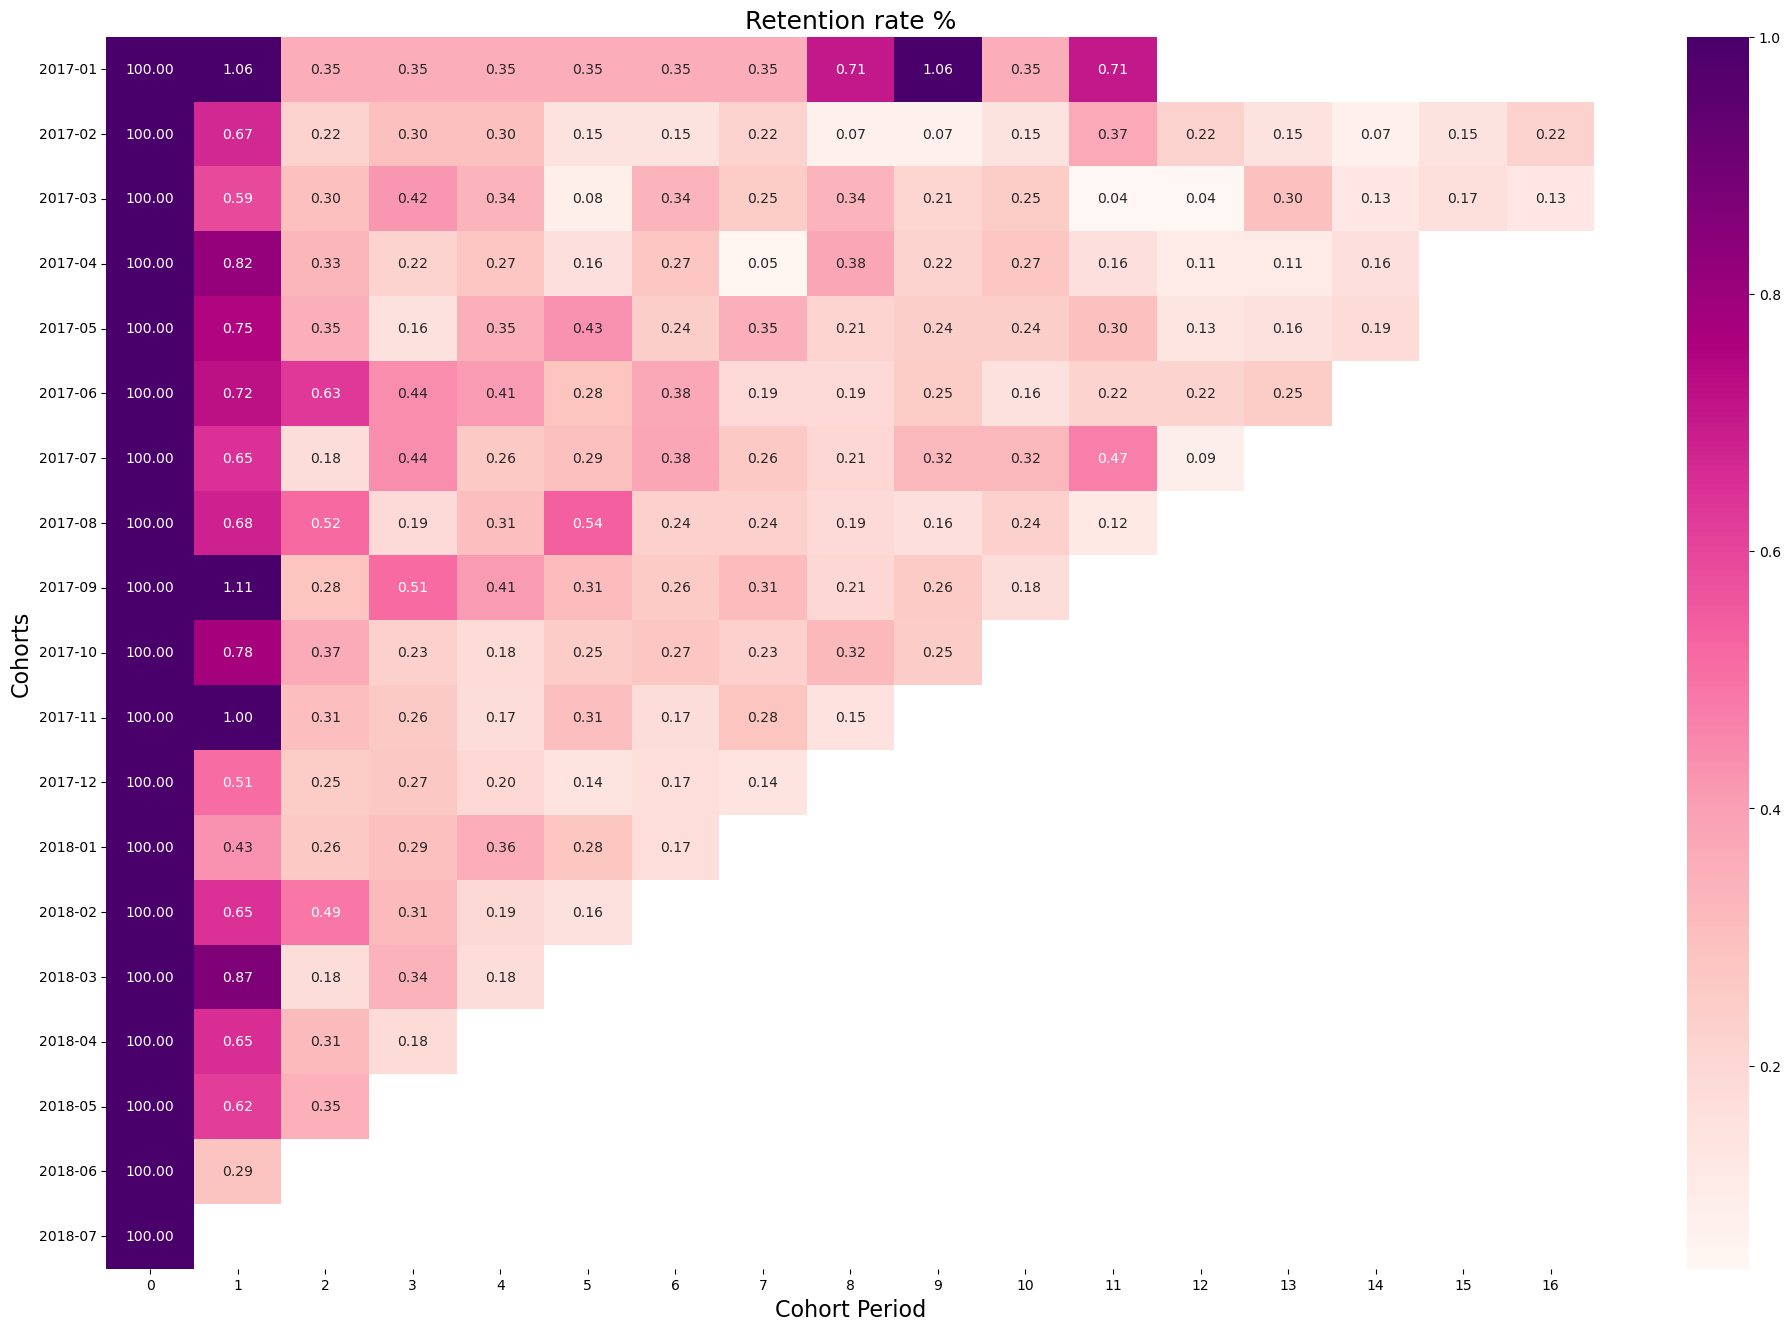

In [100]:
#построим heatmap для визуализации данных:
plt.figure(figsize=(24,16))
ax = sns.heatmap(retention, vmax=1, annot=True, fmt='.2f', cmap='RdPu')
plt.xlabel('Cohort Period',size= 16)
plt.ylabel('Cohorts', size= 16)
plt.title('Retention rate %', size= 18)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

*Ответ:* на рисунке видно, что самый высокий retention на 3-й месяц составляет 0.51% и приходится на кагорту клиентов "2017-09".  
Это говорит нам о том, что на 3-й месяц с момента первой покупки самый высокий процент удержания был у группы пользователей, которые совершили первую покупку в сентябре 2017 года.

### Задача 6. Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. 

**Решение:**

***Аббревиатура RFM расшифровывается:***

* Recency — давность (как давно клиенты приобретали товар или услуги). Высокий показатель давности означает, что у клиентов уже сложилось достаточно хорошее впечатление о нашем бренде, поэтому они недавно совершили покупку. Давность в срезе клиентской базы можно посмотреть, если отсортировать клиентов по дате последней покупки.

* Frequency — частота (как часто клиенты у нас покупают). Высокий показатель частоты говорит о том, что клиентам нравится наш бренд, товары или услуги, поэтому он часто к нам возвращается. 

* Monetary — деньги (общая сумма трат). Высокий уровень этого показателя  означает, что клиентам нравится тратить именно у нас.

Помним, что order_delivered_customer_date — это время доставки заказа клиенту.  

Мы считатем, что **покупка** - это те заказы, которые были доставлены (т.е. заказы со статусом "delivered").  
Следовательно, день недели, когда была сделана покупка - это тот день недели, когда была сделана доставка.

**df_coi** - это датафрейм с пользователями, заказами и товарами

**В кластеризации были выбраны следующие метрики:**
* R - время от последней покупки пользователя до текущей даты, 
* F - суммарное количество покупок у пользователя за всё время, 
* M - сумма покупок за всё время.  

In [106]:
# Посмотрим на датафрейм с пользователями, заказами и товарами:
df_coi.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,customer_unique_id,customer_zip_code_prefix,...,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_month,order_delivered_customer_month,order_delivered_customer_days_in_month,order_delivered_customer_week_in_month,order_delivered_customer_day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,...,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,2017-09,30.0,4.285714,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,...,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,2017-05,31.0,4.428571,Friday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,...,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,2018-01,31.0,4.428571,Monday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,...,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,2018-08,31.0,4.428571,Tuesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,...,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,2017-03,31.0,4.428571,Wednesday


In [107]:
# Отфильтруем тех пользователей, которые совершили покупку (т.е. у которых статус заказа "delivered")
# Оставим только нужные колонки для анализа. 

df_all = df_coi.query(' order_status == "delivered" ').dropna() \
                    [['order_id', 'order_delivered_customer_date', 'customer_unique_id', 'price']]

In [108]:
df_all

,order_id,order_delivered_customer_date,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-05-12 16:04:24,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-01 16:42:31,64b576fb70d441e8f1b2d7d446e483c5,199.90
...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,2018-05-10 22:56:40,0c9aeda10a71f369396d0c04dce13a64,299.99
112646,fffcd46ef2263f404302a634eb57f7eb,2018-07-23 20:31:55,0da9fe112eae0c74d3ba1fe16de0988b,350.00
112647,fffce4705a9662cd70adb13d4a31832d,2017-10-28 12:22:22,cd79b407828f02fdbba457111c38e4c4,99.90
112648,fffe18544ffabc95dfada21779c9644f,2017-08-16 21:59:40,eb803377c9315b564bdedad672039306,55.99


В наших данных сейчас для одного и того же заказа могут иметь несколько строк (по одной строке на товар).   
Однако нас интересует, сколько раз клиент покупал, а не сколько товаров он купил. Будем считать заказы, а не товары.  
Для этого создадим датафрейм, в котором для каждого клиента будет посчитана сумма заказа.

В наших данных по заказам **df_order_items** есть колонки: price - цена за единицу товара, freight_value - вес товара. Но в данных нет параметра *quantity* - количество единиц товара в заказе. При этом в таблице **df_order_items** нет дублирующих строк. Возможно, в данных не хватает информации о количестве единиц товара в заказе, и расчёты общей суммы заказа могут быть не совсем точны. 

In [109]:
# Cоздадим датафрейм, в котором для заказа, для каждого клиента будет посчитана сумма заказа:
df_all = df_all.groupby(['order_id', 'customer_unique_id', 'order_delivered_customer_date'], as_index = False) \
    .agg({'price': 'sum'}) \
    .rename(columns = {'price': 'order_price'})

df_all

,order_id,customer_unique_id,order_delivered_customer_date,order_price
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-20 23:43:48,58.90
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-05-12 16:04:24,239.90
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-22 13:19:16,199.00
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-14 13:32:39,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-03-01 16:42:31,199.90
...,...,...,...,...
96450,fffc94f6ce00a00581880bf54a75a037,0c9aeda10a71f369396d0c04dce13a64,2018-05-10 22:56:40,299.99
96451,fffcd46ef2263f404302a634eb57f7eb,0da9fe112eae0c74d3ba1fe16de0988b,2018-07-23 20:31:55,350.00
96452,fffce4705a9662cd70adb13d4a31832d,cd79b407828f02fdbba457111c38e4c4,2017-10-28 12:22:22,99.90
96453,fffe18544ffabc95dfada21779c9644f,eb803377c9315b564bdedad672039306,2017-08-16 21:59:40,55.99


In [110]:
# Приведем дату покупки (т.е. дату доставки) к нужному типу в формате 'YYYY-MM-DD'
df_all['order_delivered_customer_date'] = pd.to_datetime(df_all['order_delivered_customer_date'], format='%Y-%m-%d')

df_all.head()

,order_id,customer_unique_id,order_delivered_customer_date,order_price
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-20 23:43:48,58.90
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-05-12 16:04:24,239.90
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-22 13:19:16,199.00
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-14 13:32:39,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-03-01 16:42:31,199.90


In [111]:
# Посмотрим на временные рамки данных:
df_all.sort_values('order_delivered_customer_date')

,order_id,customer_unique_id,order_delivered_customer_date,order_price
20500,36989eb07a0de2d3d3129eea35553875,f176923a0a4ab546c7287791ccb82193,2016-10-11 13:46:32,47.80
42256,7033745709b7cf1bac7d2533663592de,1dc848c11c2985635c268ff3dea707eb,2016-10-11 14:46:49,93.90
79184,d1eb8e4e276a4eea13a5c462c0765e60,f99053da7416fd6d626451cd49e44e0f,2016-10-13 03:10:34,19.99
54940,92b44b87f1f7670b8911c5f0e642435e,acf599349b44e4e51d2beacb549313ad,2016-10-13 07:45:48,149.99
64677,ac2b7c522d811acba0aa270ed3e112e4,664f7107c351f24b16b68919398730a0,2016-10-13 15:44:27,294.90
...,...,...,...,...
47043,7d09831e67caa193da82cfea3bee7aa5,c9f2b70eaddf459267a9de373aaf743b,2018-09-25 00:47:25,49.90
61004,a2b4be96b53022618030c17ed437604d,3ae68a873484afec224de126a94c5974,2018-09-27 02:24:33,209.99
67171,b2997e1d7061605e9285496c581d1fbd,4bc530761c1b59d33d7c6cb640d3ee78,2018-10-02 00:18:50,70.00
25997,450cb96c63e1e5b49d34f223f67976d2,232422c2db1f7c69daf3b0f0421ebb43,2018-10-11 16:41:14,179.00


Следовательно, в наших данных - есть даты от "2016-10-11" до "2018-10-17"

#### Посчитаем R (Recency) - время от последней покупки пользователя до текущей даты:

In [112]:
# Ищем дату самой последней покупки:
NOW = df_all.order_delivered_customer_date.max()

NOW
# Будем далее считать, что это текущая дата.

Timestamp('2018-10-17 13:22:46')

In [113]:
# Добавим в данные столбец с количеством дней между днем покупки (т.е. днем доставки) и текущей датой (т.е. датой '2018-10-17'):
df_all['DaysSinceOrder'] = df_all['order_delivered_customer_date'].apply(lambda x: (NOW - x).days)

# Чтобы найти значения недавности (R - Recency), нужно найти минимум этого столбца (DaysSinceOrder) для каждого клиента.
df_Recency = df_all.groupby('customer_unique_id', as_index=False)\
    .agg({'DaysSinceOrder': 'min'})\
    .rename(columns = {'DaysSinceOrder': 'Recency'})

df_Recency

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,153
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159
2,0000f46a3911fa3c0805444483337064,559
3,0000f6ccb0745a6a4b88665a16c9f078,349
4,0004aac84e0df4da2b147fca70cf8255,323
...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,468
93332,fffea47cd6d3cc0a88bd621562a9d061,280
93333,ffff371b4d645b6ecea244b27531430a,602
93334,ffff5962728ec6157033ef9805bacc48,156


#### Посчитаем F (Frequency) - суммарное количество покупок у пользователя за всё время:¶

In [52]:
# Для каждого пользователя посчитаем общее число покупок (покупка - это доставленный заказ):
df_Frequency = df_all.groupby('customer_unique_id', as_index = False)\
    .agg({'order_id': 'count'})\
    .rename(columns = {'order_id': 'Frequency'})

df_Frequency

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,1
93332,fffea47cd6d3cc0a88bd621562a9d061,1
93333,ffff371b4d645b6ecea244b27531430a,1
93334,ffff5962728ec6157033ef9805bacc48,1


#### Посчитаем M (Monetary) - сумма покупок за всё время:¶

In [53]:
# Для каждого пользователя посчитаем общую сумму покупок (покупка - это доставленный заказ):
df_Monetary = df_all.groupby('customer_unique_id', as_index = False)\
    .agg({'order_price': 'sum'})\
    .rename(columns = {'order_price': 'Monetary'})

df_Monetary

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
93332,fffea47cd6d3cc0a88bd621562a9d061,64.89
93333,ffff371b4d645b6ecea244b27531430a,89.90
93334,ffff5962728ec6157033ef9805bacc48,115.00


In [54]:
# Собедем общий датафрейм, в котором для каждого клиента посчитано Recency, Frequency и Monetary:
df_rfm = df_Recency.merge(df_Frequency, on = 'customer_unique_id', how = 'inner')\
                   .merge(df_Monetary, on = 'customer_unique_id', how = 'inner')

df_rfm

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,18.90
2,0000f46a3911fa3c0805444483337064,559,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,323,1,180.00
...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,468,1,1570.00
93332,fffea47cd6d3cc0a88bd621562a9d061,280,1,64.89
93333,ffff371b4d645b6ecea244b27531430a,602,1,89.90
93334,ffff5962728ec6157033ef9805bacc48,156,1,115.00


#### Рассчитем баллы R, F и M.

In [56]:
# посмотрим статистику:
df_rfm.describe()

,Recency,Frequency,Monetary
count,93336.000000,93336.000000,93336.000000
mean,273.100133,1.033417,141.621663
std,151.926681,0.209098,215.714143
min,0.000000,1.000000,0.850000
25%,152.000000,1.000000,47.650000
50%,252.000000,1.000000,89.700000
75%,383.000000,1.000000,154.692500
max,735.000000,15.000000,13440.000000


Чтобы получить оценку RFM клиента, нам нужно сначала рассчитать оценки R, F и M по шкале от 1 (худший) до 4 (лучший).
Основываясь на статистических данных, есть смысл разделять сегменты для Recency и Monetary через квартили. Первый квартиль — это точка, ниже которой лежат 25% всех значений данных. Второй квинтиль — это точка, ниже которой лежат 50 % всех значений данных. Третий квартиль - это точка, ниже которой лежат 75% всех значений данных. Для Frequency 1-ый, 2-ой и 3-ий квартиль принимает одно значение - 1, поэтому есть смысл для Frequency задать всего 2 сегмента: Frequency = 1, и Frequency > 1.

In [60]:
# Посчитаем квантили для каждого параметра Recency, 'Frequency' и 'Monetary':
quartiles = df_rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.5, 0.75]).to_dict()
quartiles

{'Recency': {0.25: 152.0, 0.5: 252.0, 0.75: 383.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 47.65, 0.5: 89.7, 0.75: 154.6925}}

Запишем методы для присвоения рангов от 1 (худший) до 4 (лучший). 
Чем меньше значение Recency, тем лучше, тогда как более высокие значения Frequency и Monetary лучше.   
*Recency*: меньше значение - больше балл  
*Frequency*: меньше значение - меньше балл  
*Monetary*: меньше значение - меньше балл  
Поэтому нужно написать две отдельных функции для присвоения рангов.   

In [61]:
# Напишем две отдельных функции для присовения рангов от 1 до 4:
def r_score(x):
    if x <= quartiles['Recency'][0.25]:
        return 4
    elif x <= quartiles['Recency'][0.5]:
        return 3
    elif x <= quartiles['Recency'][0.75]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quartiles['Monetary'][0.25]:
        return 1
    elif x <= quartiles['Monetary'][0.5]:
        return 2
    elif x <= quartiles['Monetary'][0.75]:
        return 3
    else:
        return 4    

def f_score(x):
    if x <= 1:
        return 1
    else:
        return 2        

In [62]:
# Получим оценки R, F и M для каждого клиента (т.е. добавим баллы для каждого клиента):
df_rfm['R'] = df_rfm['Recency'].apply(lambda x: r_score(x))
df_rfm['F'] = df_rfm['Frequency'].apply(lambda x: f_score(x))
df_rfm['M'] = df_rfm['Monetary'].apply(lambda x: m_score(x))

In [63]:
df_rfm

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,129.90,3,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,559,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,323,1,180.00,2,1,4
...,...,...,...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,468,1,1570.00,1,1,4
93332,fffea47cd6d3cc0a88bd621562a9d061,280,1,64.89,2,1,2
93333,ffff371b4d645b6ecea244b27531430a,602,1,89.90,1,1,3
93334,ffff5962728ec6157033ef9805bacc48,156,1,115.00,3,1,3


Добавим новый столбец с названием 'RFM Score' в DataFrame *df_rfm*, который содержит комбинацию значений из столбцов 'R', 'F' и 'M' в виде строковых значений.  

Для этого применяим метод 'map' к каждому столбцу 'R', 'F' и 'M' для преобразования числовых значений в соответствующие строковые значения, а затем объединим эти строки в одну строку, добавляя их в новый столбец 'RFM Score'.  

Таким образом, столбец 'RFM Score' будет содержать значения, которые представляют комбинацию количественных показателей 'R', 'F' и 'M', используемых в анализе RFM (Recency, Frequency, Monetary).  

In [64]:
# Добавим новый столбец 'RFM_Score', содержащий комбинацию столбцов 'R', 'F' и 'M' в виде строковых значений:
df_rfm['RFM_Score'] = df_rfm['R'].map(str) + df_rfm['F'].map(str) + df_rfm['M'].map(str)
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,559,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,323,1,180.00,2,1,4,214


Оценки RFM дают нам (4^2)*2 = 16 сегментов. С которым не просто работать.  
Будем работать с 8 сегментами на основе показателей R, F и M.   
Вот описание сегментов:
* champions: последняя покупка недавно, покупают часто, траты большие (R-score 3-4; F-score 2; M-score 3-4);
* loyal_customers: последняя покупка недавно, покупают часто, траты небольшие (R-score 3-4; F-score 2; M-score 1-2);
* promising: последняя покупка недавно, покупают нечасто, траты большие (R-score 3-4; F-score 1; M-score 3-4);
* new_customers: последняя покупка недавно, покупают нечасто, траты небольшие (R-score 3-4; F-score 1; M-score 1-2);
* can’t_lose_them: последняя покупка давно, покупали часто, траты большие (R-score 1-2; F-score 2; M-score 3-4);
* customers_needing_attention: последняя покупка давно, покупали часто, траты небольшие (R-score 1-2; F-score 2; M-score 1-2);
* at_risk: последняя покупка давно, покупали нечасто, траты большие (R-score 1-2; F-score 1; M-score 3-4);
* hibernating: последняя покупка давно, покупали нечасто, траты небольшие (R-score 1-2; F-score 1; M-score 1-2).

In [67]:
#создаем словарь, в который запишем название каждого сегмента:
segments = {
    r'[3-4][2][3-4]': 'champions',
    r'[3-4][2][1-2]': 'loyal_customers',
    r'[3-4][1][3-4]': 'promising',
    r'[3-4][1][1-2]': 'new_customers',
    r'[1-2][2][3-4]': 'can’t_lose_them',
    r'[1-2][2][1-2]': 'customers_needing_attention',
    r'[1-2][1][3-4]': 'at_risk',
    r'[1-2][1][1-2]': 'hibernating'
    }

# добавим в датафрейм столбец, содержащий название сегмента:
df_rfm['Segment'] = df_rfm['RFM_Score'].replace(segments, regex=True)
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,129.90,3,1,3,313,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,18.90,3,1,1,311,new_customers
2,0000f46a3911fa3c0805444483337064,559,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,25.99,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,323,1,180.00,2,1,4,214,at_risk


#### Визуалирируем результат

In [68]:
# посчитаем количество клиентов в каждом сегменте
segments_counts = df_rfm\
                    .groupby('Segment', as_index = False)\
                    .agg({'RFM_Score': 'count'})\
                    .rename(columns = {'RFM_Score': 'Segments_counts'})\
                    .sort_values('Segments_counts', ascending = False)
segments_counts

,Segment,Segments_counts
4,hibernating,23425
6,new_customers,22787
7,promising,22352
0,at_risk,21972
2,champions,1303
1,can’t_lose_them,1039
5,loyal_customers,235
3,customers_needing_attention,223


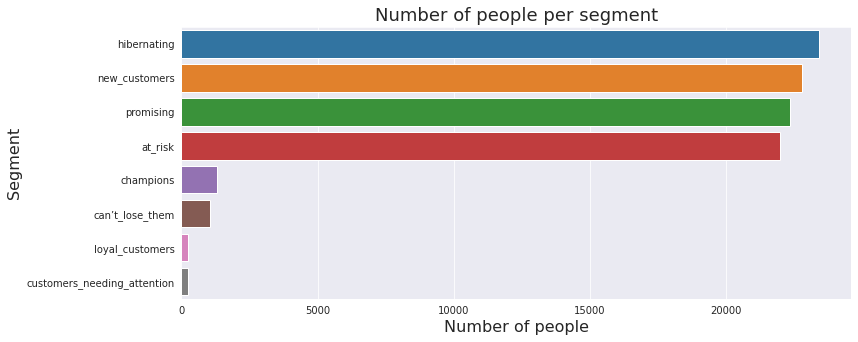

In [69]:
plt.figure(figsize = (12, 5))
sns.set_style("darkgrid")
ax = sns.barplot(data = segments_counts, y = 'Segment', x= 'Segments_counts')
plt.xlabel('Number of people',size= 16)
plt.ylabel('Segment', size= 16)
plt.title('Number of people per segment', size= 18)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

**Выводы:**  
1. Самая большая часть клиентов - это те, кто покупают нечасто (сегменты hibernating, at_risk, new_customers, promising), что вероятно, может быть связано со спецификой товара.  
2. Самая большая доля клиентов - это те, кто совершил 1-2 покупки достаточно давно и на небольшую сумму (сегмент hibernating).  
3. Покупатели не возвращаются в магазин за повторными покупками так как у нас очень мало покуателей, которые покупают часто и в которых последняя покупка была недавно (сегменты champions и loyal_customers).   
4. Предлагается привлечь покупателей, которые покупали часто, но давно (сегменты can’t_lose_them, customers_needing_attention), а также покупателей, которые покупали давно, нечасто, но на большие суммы (сегмент at_risk), c помощью рекламных акций.   